In [2]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15

IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and

In [4]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

# Generate batches of image data with real-time augmentation (none here)
train_data_gen = train_image_generator.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

val_data_gen = validation_image_generator.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'
)

# Build a DataFrame with filenames
test_filenames = os.listdir(test_dir)
df_test = pd.DataFrame({
    'filename': test_filenames
})

# Load images using flow_from_dataframe
test_image_generator = ImageDataGenerator(rescale=1./255)

test_data_gen = test_image_generator.flow_from_dataframe(
    dataframe=df_test,
    directory=test_dir,              # where to look for images
    x_col='filename',                # column with file names
    y_col=None,                      # no labels for test
    class_mode=None,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    shuffle=False                    # don't shuffle test data
)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


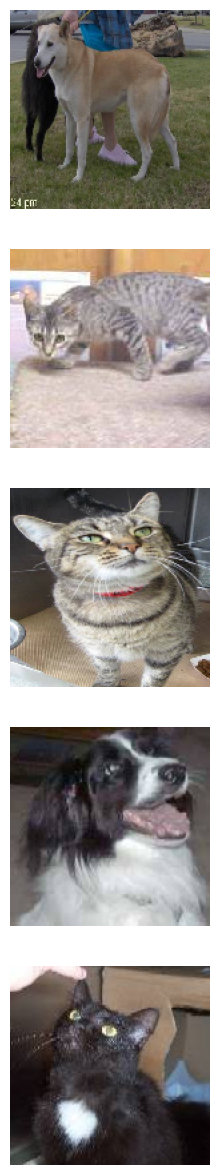

In [5]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [6]:
train_image_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


Found 2000 images belonging to 2 classes.


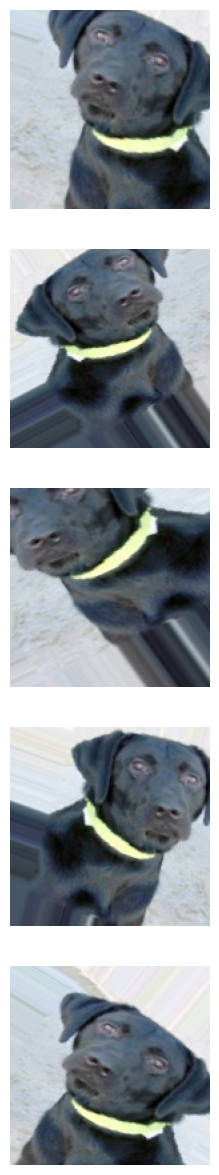

In [7]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [8]:
# 7

# 2. Build model with MobileNetV2 base
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 3. Callbacks
rlrop = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


model.summary()

<ipython-input-8-846285268>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [10]:
# 8
# 4. Train top layers
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
    callbacks=[rlrop, early]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6204 - loss: 0.7326 - val_accuracy: 0.9140 - val_loss: 0.2357 - learning_rate: 0.0010
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 902ms/step - accuracy: 0.8354 - loss: 0.3529 - val_accuracy: 0.9360 - val_loss: 0.1734 - learning_rate: 0.0010
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 899ms/step - accuracy: 0.8782 - loss: 0.3026 - val_accuracy: 0.9380 - val_loss: 0.1670 - learning_rate: 0.0010
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 907ms/step - accuracy: 0.8830 - loss: 0.2592 - val_accuracy: 0.9440 - val_loss: 0.1426 - learning_rate: 0.0010
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 986ms/step - accuracy: 0.8643 - loss: 0.2759 - val_accuracy: 0.9480 - val_loss: 0.1377 - learning_rate: 0.0010
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 902ms/step - accuracy: 0.8958 - loss: 0.2479 - val_accuracy: 0.9470 - val_loss: 0.1439 - learning_rate: 0.0010
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 918ms/step - accuracy: 0.9119 - loss: 0.207

In [ ]:
# 8
# 4. Train top layers
history = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
    callbacks=[rlrop, early]
)

# 5. Fine-tune deeper layers (optional)
base_model.trainable = True
# Freeze first N layers if desired
for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_data_gen,
    epochs=epochs,
    validation_data=val_data_gen,
    callbacks=[rlrop, early]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.6204 - loss: 0.7326 - val_accuracy: 0.9140 - val_loss: 0.2357 - learning_rate: 0.0010
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 902ms/step - accuracy: 0.8354 - loss: 0.3529 - val_accuracy: 0.9360 - val_loss: 0.1734 - learning_rate: 0.0010
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 899ms/step - accuracy: 0.8782 - loss: 0.3026 - val_accuracy: 0.9380 - val_loss: 0.1670 - learning_rate: 0.0010
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 907ms/step - accuracy: 0.8830 - loss: 0.2592 - val_accuracy: 0.9440 - val_loss: 0.1426 - learning_rate: 0.0010
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 986ms/step - accuracy: 0.8643 - loss: 0.2759 - val_accuracy: 0.9480 - val_loss: 0.1377 - learning_rate: 0.0010
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 902ms/step - accuracy: 0.8958 - loss: 0.2479 - val_accuracy: 0.9470 - val_loss: 0.1439 - learning_rate: 0.0010
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 918ms/step - accuracy: 0.9119 - loss: 0.207

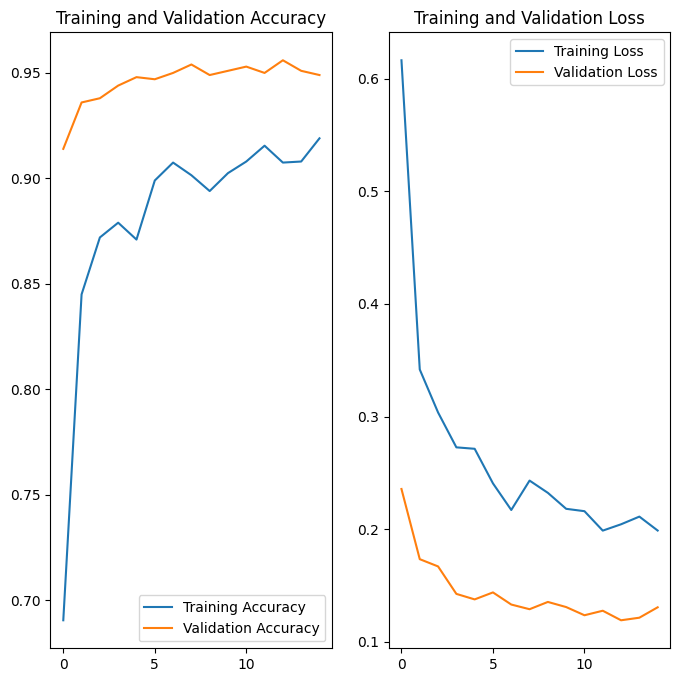

In [14]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [2]:
# Ground truth answers (for evaluation)
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

# Load one batch of images from test generator (returns numpy array of images)
test_images = next(test_data_gen)
plotImages(test_images)

# Predict probabilities
pred = model.predict(test_images)


probabilities = pred.flatten()

# Plot images with probabilities

# Evaluate accuracy comparing predictions (threshold at 50%)
correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

NameError: name 'test_data_gen' is not defined